In [3]:
import numpy as np
import pandas as pd
import sys
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn
import lazypredict
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import itertools
from sklearn.impute import KNNImputer
import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import FunctionTransformer
from fitter import Fitter, get_common_distributions, get_distributions
import time
from datetime import datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib
from scipy.spatial.distance import cdist
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

In [4]:
def cast_district(x):
    return x.replace("NeukÃ¶lln","Neukölln").replace('Tempelhof - SchÃ¶neberg','Tempelhof - Schöneberg').replace('Treptow - KÃ¶penick','Treptow - Köpenick').replace('Charlottenburg-Wilm.','Charlottenburg-Wilmersdorf').replace('Ã¶','ö').replace('Ã¤','ä').replace('Ã','ß')

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

def get_training_data(data_files):
    df_train = pd.read_csv(data_files['train_airbnb'])
    
    metro_stations_df = pd.read_csv(data_files['berlin_metro_stations'])[['name','station_category','metro_latitude','metro_longitude']]
    bus_stations_df = pd.read_csv(data_files['berlin_bus_stations'])[['name','bus_latitude','bus_longitude']]
    tramway_stations_df = pd.read_csv(data_files['berlin_tramway_stations'])[['name','tramway_latitude','tramway_longitude']]
    metro_stations_df['point'] = [(x, y) for x,y in zip(metro_stations_df['metro_latitude'], metro_stations_df['metro_longitude'])]
    bus_stations_df['point'] = [(x, y) for x,y in zip(bus_stations_df['bus_latitude'], bus_stations_df['bus_longitude'])]
    tramway_stations_df['point'] = [(x, y) for x,y in zip(tramway_stations_df['tramway_latitude'], tramway_stations_df['tramway_longitude'])]

    df_train['point'] = [(x, y) for x,y in zip(df_train['Latitude'], df_train['Longitude'])]
    df_train['closest'] = [closest_point(x, list(metro_stations_df['point'])) for x in df_train['point']]
    df_train[['closest_metro_latitude','closest_metro_longitude']] = pd.DataFrame(df_train['closest'].tolist(),index=df_train.index)
    df_train['metro_category'] = [match_value(metro_stations_df, 'point', x, 'station_category') for x in df_train['closest']]
    df_train['distance_to_closest_metro'] = haversine(df_train['Latitude'], df_train['Longitude'], df_train['closest_metro_latitude'], df_train['closest_metro_longitude'])
    df_train = df_train.drop(['point','closest','closest_metro_latitude','closest_metro_longitude'], axis=1)
    df_train['point'] = [(x, y) for x,y in zip(df_train['Latitude'], df_train['Longitude'])]
    df_train['closest'] = [closest_point(x, list(bus_stations_df['point'])) for x in df_train['point']]
    df_train[['closest_bus_latitude','closest_bus_longitude']] = pd.DataFrame(df_train['closest'].tolist(),index=df_train.index)
    df_train['distance_to_closest_bus'] = haversine(df_train['Latitude'], df_train['Longitude'], df_train['closest_bus_latitude'], df_train['closest_bus_longitude'])
    df_train = df_train.drop(['point','closest','closest_bus_latitude','closest_bus_longitude'], axis=1)
    df_train['point'] = [(x, y) for x,y in zip(df_train['Latitude'], df_train['Longitude'])]
    df_train['closest'] = [closest_point(x, list(tramway_stations_df['point'])) for x in df_train['point']]
    df_train[['closest_tramway_latitude','closest_tramway_longitude']] = pd.DataFrame(df_train['closest'].tolist(),index=df_train.index)
    df_train['distance_to_closest_tramway'] = haversine(df_train['Latitude'], df_train['Longitude'], df_train['closest_tramway_latitude'], df_train['closest_tramway_longitude'])
    df_train = df_train.drop(['point','closest','closest_tramway_latitude','closest_tramway_longitude'], axis=1)

    crimes_df = pd.read_csv(data_files['berlin_crimes'])
    crimes_df = crimes_df.groupby(['District','Year']).sum().groupby('District').mean().drop('Code', axis=1)

    demographics_df = pd.read_csv(data_files['berlin_demographics'], delimiter=';', encoding='latin-1')
    demographics_df['Code Postal'] = demographics_df.apply(lambda x: x['Bezirk']*10000+x['Ortsteil']*10+x['Geschl'], axis=1)
    demographics_df = demographics_df[['Code Postal', 'Bez-Name', 'Ortst-Name', 'Staatsangeh','Altersgr', 'Häufigkeit']]
    demographics_df = demographics_df.rename(columns = {"Bez-Name":"District","Häufigkeit": "Population", "Altersgr":"Tranche d'âge","Staatsangeh":"Origine"})
    number_of_inhabitants_df = demographics_df.groupby(['Code Postal','District','Ortst-Name']).sum()
    number_of_germans_df = demographics_df.groupby(['Code Postal','District','Ortst-Name','Origine']).sum().query('Origine=="D"').rename(columns = {"Population":"Nb Allemands"})
    number_of_immigrants_df = demographics_df.groupby(['Code Postal','District','Ortst-Name','Origine']).sum().query('Origine=="A"').rename(columns = {"Population":"Nb Immigrants"})
    demographics_df = number_of_inhabitants_df.merge(number_of_germans_df, how='inner', on=['Code Postal','District','Ortst-Name']).merge(number_of_immigrants_df, how='inner', on=['Code Postal','District','Ortst-Name'])
    demographics_df['Proportion Allemands'] = demographics_df.apply(lambda x: x['Nb Allemands']/x['Population'], axis=1)
    demographics_df['Proportion Immigrants'] = demographics_df.apply(lambda x: x['Nb Immigrants']/x['Population'], axis=1)
    demographics_df = demographics_df[['Population','Proportion Allemands','Proportion Immigrants']]

    extra_data_df = demographics_df.reset_index().merge(crimes_df, how='left', on='District')
    for column in extra_data_df.columns:
        if column in ['Robbery','Street_robbery', 'Injury', 'Agg_assault', 'Threat', 'Theft', 'Car','From_car', 'Bike', 'Burglary', 'Fire', 'Arson', 'Damage', 'Graffiti','Drugs', 'Local']:
            extra_data_df[column] = extra_data_df.apply(lambda x: x[column]/x['Population'], axis=1)
    
    extra_data_df = extra_data_df.drop_duplicates(['Ortst-Name'])

    df_train['neighbourhood'] = df_train['neighbourhood'].apply(lambda x:cast_district(x))
    df_train['Neighborhood Group'] = df_train['Neighborhood Group'].apply(lambda x:cast_district(x))
    df_train = df_train.merge(extra_data_df, how='left', left_on='neighbourhood', right_on='Ortst-Name')

    return df_train

In [5]:
data_files = {
    "train_airbnb": "../DATA/train_airbnb_berlin.xls",
    "berlin_crimes": "../DATA/extra_datasets/Berlin_crimes.csv",
    "berlin_demographics": "../DATA/extra_datasets/Berlin_demographics.csv",
    "berlin_bus_stations": "../DATA/extra_datasets/Berlin_bus_stations.csv",
    "berlin_tramway_stations": "../DATA/extra_datasets/Berlin_tramway_stations.csv",
    "berlin_metro_stations": "../DATA/extra_datasets/Berlin_metro_stations.csv",
}

df_train = get_training_data(data_files)

# Pre processing

### Feature analysis

In [14]:
def get_subplot_analysis():
    plt.subplot(221)
    df_train.boxplot(column='Price')

    plt.subplot(222)
    df_train.boxplot(column='Square Feet')

    plt.subplot(223)
    df_train.boxplot(column='Value Rating')

    plt.subplot(224)
    df_train.boxplot(column='Accuracy Rating')

    plt.show()

In [9]:
def percentage_of_nans(df: pd.DataFrame) -> list:
    nan_percentage = pd.DataFrame(columns=['Feature Name', 'Percentage of NaNs'])
    for idx, feature in enumerate(df.columns):
        notnans = df_train[feature].notna().value_counts()
        percentage = 0
        if False in notnans:
            percentage = int(10000*notnans[False]/len(df_train))/100

        nan_percentage.loc[idx] = [feature, percentage]
    return nan_percentage

In [10]:
def nan_percentage_analysis():
    nan_percentage = percentage_of_nans(df_train)
    df = nan_percentage[nan_percentage['Percentage of NaNs'] >= 18]
    display(df.sort_values(by=['Percentage of NaNs'], ascending=False).reset_index().drop(['index'], axis=1))

In [11]:
nan_percentage_analysis()

,Feature Name,Percentage of NaNs
0,Square Feet,98.06
1,metro_category,67.02
2,Host Response Time,45.08
3,Host Response Rate,45.08
4,Checkin Rating,18.94
5,Accuracy Rating,18.93
6,Location Rating,18.93
7,Value Rating,18.93
8,Cleanliness Rating,18.92
9,Communication Rating,18.92


In [ ]:
X_train.info()

### Data cleaning

In [12]:
def pre_process_raw(df: pd.DataFrame):
    df = df.copy()
    df.columns = df.columns. str.lower().str.replace(' ','_')         

    # Converting to datetime
    df.host_since = pd.to_datetime(df.host_since)               

    cols_to_drop = ['listing_name', 'host_id', 'host_name', 'city', 'country_code', 'country', 
                    'first_review', 'last_review', 'neighbourhood', 'business_travel_ready',  'postal_code', 'district', 'ortst-name', 'code_postal']

    df = df.drop(cols_to_drop, axis=1)
    df.set_index('listing_id', inplace=True)

    df.drop(['square_feet'], axis=1, inplace=True)

    for col in df.columns:
        df[col] = df[col].replace('*', np.nan)

    df = df.dropna(subset=['price'], how='all')
    df = df.dropna(subset=['overall_rating', 'accuracy_rating','cleanliness_rating','checkin_rating',
                            'communication_rating','location_rating','value_rating'], how='all')
    
    numerical_features = ['accomodates','latitude',
          'longitude','bathrooms','bedrooms','beds','guests_included','min_nights','reviews','overall_rating','accuracy_rating',
          'cleanliness_rating','checkin_rating', 'communication_rating','location_rating','value_rating']

    label_encoded = ['host_response_time', 'is_superhost', 'is_exact_location', 'instant_bookable']

    categorical_variables = ['room_type', 'property_type','neighborhood_group'] 
    for i in numerical_features:
        df[i]=pd.to_numeric(df[i], downcast="float")

    #Replacing the null values

    df['host_response_rate'] = df['host_response_rate'].map(lambda x: str(x), na_action='ignore').map(lambda x : int(x[:-1]), na_action='ignore') 

    for cat_var in categorical_variables:
        dummie = pd.get_dummies(df[cat_var])
        df = pd.concat([df, dummie], axis=1)

    df.drop(categorical_variables, axis=1, inplace=True)
    
    le = LabelEncoder()
    for i in label_encoded:
        df[i] = le.fit_transform(df[i].astype(str))
    
    X = df.drop('price', axis = 1)

    # Output/Dependent variable

    y = df['price']
    return X, y

def median_imputer(df: pd.DataFrame):
    numerical_features = ['accomodates','latitude',
        'longitude','bathrooms','bedrooms','beds','guests_included','min_nights','reviews','overall_rating','accuracy_rating',
        'cleanliness_rating','checkin_rating', 'communication_rating','location_rating','value_rating' ]
    
    df = df.copy()

    if 'host_since' in df.columns:
        # Calculating the number of days    
        df['host_days_active'] = (datetime(2019, 7, 21) - df.host_since).astype('timedelta64[D]').copy()

        # Replacing null values with the median
        df['host_days_active'] = df.host_days_active.fillna(df.host_days_active.median()).copy()

        df['host_days_active'] = (datetime(2019, 7, 21) - df.host_since).astype('timedelta64[D]').copy()
        df.drop('host_since', axis=1, inplace=True)

    for col in numerical_features:
        if col not in df.columns:continue
        df[col].fillna(df[col].median(), inplace=True)

    df = df.fillna(0).copy()

    return df

In [30]:
def fit_clf_scaler_cv(clf, X, y, clf_params, pipeline_params={}, n_features=55):
    X = X.copy()
    y = y.copy()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    
    rmse_list = []
    r2_list = []
    X = median_imputer(X)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_features)),
        ('svr', clf(**clf_params))], **pipeline_params)
        
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_test)
        rmse = mean_squared_error(y_pred, y_test)**(1/2)
        rmse_list.append(rmse)
        r2_list.append(pipe.score(X_test, y_test))
    return np.array(rmse_list).mean(), np.array(r2_list).mean()

def fit_clf_scaler(clf, X, y, clf_params, pipeline_params={}, n_features=50):
    X = X.copy()
    y = y.copy()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    pipe = Pipeline([('median_imputer', FunctionTransformer(median_imputer)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_features)),
    ('svr', clf(**clf_params))], **pipeline_params)
    
    pipe.fit(X,y)
    return pipe 

In [14]:
X, y = pre_process_raw(df_train)

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from scipy.special import rel_entr
from scipy.stats import burr
f = Fitter(y.values,
           distributions=["burr"])
f.fit()
x = np.arange(0, 600, 1)
r_train = burr.pdf(x, **(f.get_best()['burr']))
plt.plot(r_train*65000, label='Burr', c='r', linewidth=2, linestyle='--')
plt.title("Price Distribution", weight='bold')
plt.hist(y_train,bins=100, label='train')
plt.hist(y_test, bins=100,label='test')
plt.legend()
plt.grid(linewidth=0.4)
plt.xlabel('Price', fontsize=16, weight='bold')
plt.xlim((0, 400))
plt.ylabel('Quantity', fontsize=16, weight='bold')
plt.tight_layout()


plt.savefig('price_distribution.pdf')

### Train test split

In [31]:
def get_train_test_analysis():
    plt.hist(y_train,bins=100, label='train')
    plt.hist(y_test, bins=100,label='test')
    plt.legend()
    plt.grid(axis='x')
    plt.show()

    f = Fitter(y.values,
            distributions=['gamma',
                            'lognorm',
                            "beta",
                            "burr",
                            "norm"])
    f.fit()
    f.summary()

    f_train = Fitter(y_train.values, distributions=['burr'])
    f_train.fit()

    display(f_train.get_best())

    f_test = Fitter(y_test.values, distributions=['burr'])
    f_test.fit()
    display(f_test.get_best())


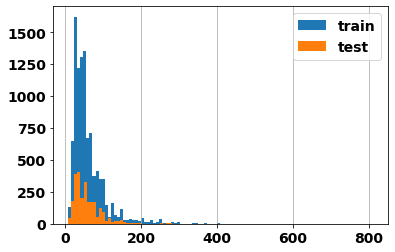

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


{'burr': {'c': 2.3918847639235943,
  'd': 2.6672527926210923,
  'loc': -0.0923998227354602,
  'scale': 28.50641342786434}}

Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]


{'burr': {'c': 2.5829527482788075,
  'd': 1.8337441549196827,
  'loc': -0.10671963192032685,
  'scale': 35.77353089594571}}

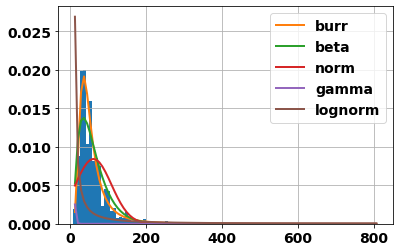

In [34]:
get_train_test_analysis()

# Latitude Longitude influence

Text(0, 0.5, 'Latitude')

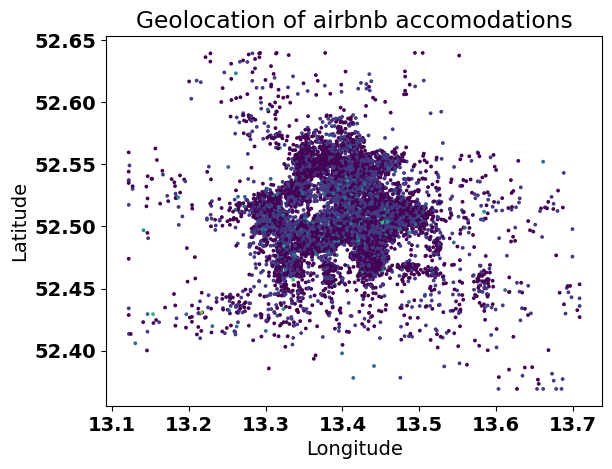

In [95]:
plt.title('Geolocation of airbnb accomodations')
plt.scatter(df_train['Longitude'], df_train['Latitude'], s=3, c=df_train['price_categories'], label=df_train['price_categories'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [108]:
categories = []
def map_price(x):
    for k in range(50, 700, 100):
        if x < k:
            return k

df_train['price_categories'] = df_train['Price'].map(map_price)

In [121]:
import plotly.express as px
df = df_train[['Longitude', 'Latitude', 'Price']]
fig = px.scatter(df, x="Longitude", y="Latitude", color='Price')
fig.update_xaxes(range=[13.2, 13.6])
fig.update_yaxes(range=[52.4,52.65])
fig.update_coloraxes(cmax=300, cmin=0)
fig.show()


In [90]:
df_train['price_categories'].value_counts()

0.5    8023
1.5    6930
2.5     563
3.5     114
4.5      30
5.5       7
6.5       4
Name: price_categories, dtype: int64

# Feature analysis

### PCA

In [22]:
def make_pca_analysis():
    pipe = Pipeline([('median_imputer', FunctionTransformer(median_imputer)),
    ('scaler', StandardScaler()),
    ('pca', PCA())])

    pipe.fit(X_train)
    explained_variance = pipe['pca'].explained_variance_ratio_
    acc_sum = np.cumsum(explained_variance) 

    plt.title('Cumulative explained variance')
    plt.plot(acc_sum)
    plt.grid()
    plt.ylabel('Explained variance')
    plt.xlabel('Number of features')
    plt.plot(50, 0.99132,'ro') 
    plt.show()

    print('Explained variance with 51 features: ', acc_sum[55])

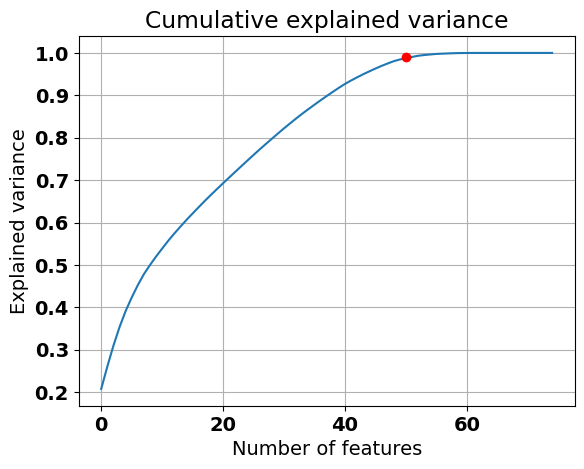

Explained variance with 51 features:  0.9976132250237079


In [23]:
make_pca_analysis()

In [103]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max())
    f.savefig("matrix.pdf")
    

### Forward selection + Cross Validation

In [13]:
def get_feature_importance(clf, params):
	r2 = [] 
	rmse = []
	features = []
	n_features = []

	for k in range(1,len(X.columns) + 1):
		r2_tmp = []
		rmse_tmp = []
		for new_feat in X_train.columns:
			if new_feat in features: continue
			new_features = features.copy()
			new_features.append(new_feat)
			pipe = fit_clf_scaler(clf, X_train[new_features],y_train, params, {}, n_features=len(new_features))   
			r_squared = pipe.score(X_test[new_features],y_test)
			y_pred = pipe.predict(X_test[new_features])
			rmse_val = mean_squared_error(y_pred, y_test)**(1/2)
			r2_tmp.append((r_squared, new_feat))                 
			rmse_tmp.append(rmse_val)
		r2.append(sorted(r2_tmp, key=lambda x: x[0])[-1][0])	
		rmse.append(sorted(rmse_tmp)[-1])
		new_feat = sorted(r2_tmp, key=lambda x: x[0])[-1][1]
		features.append(new_feat)
		n_features.append(len(features))   

	df = pd.DataFrame({'n_features': n_features,'R2': r2, 'RMSE':rmse ,'features':features})

	return df

In [14]:
def get_subset_selection_analysis():
    df = get_feature_importance(linear_model.LinearRegression, {})
    plt.title('Cross-validated subset selection - Linear Regression')
    plt.xlabel('Number of features')
    plt.ylabel('R squared')
    plt.grid()
    plt.plot(df['n_features'], df['R2'])
    plt.show()

    plt.title('Cross-validated subset selection - Linear Regression')
    plt.xlabel('Number of features')
    plt.ylabel('RMSE')
    plt.grid()
    plt.plot(df['n_features'], df['RMSE'])
    plt.show()


# Model selection

### Decision Trees

#### Analysis

In [104]:
def get_decision_tree_analysis():
    rmse = []
    max_depth = []
    for k in range(1, 30):
        rmse_val = fit_clf_scaler_cv(DecisionTreeRegressor, X_train,y_train, {"max_depth": k}, {"verbose": 0}, n_features=25) 
        rmse.append(rmse_val)	
        max_depth.append(k)

    df = pd.DataFrame({'RMSE': rmse,'max_depth':max_depth})
    plt.title('Influence of the max depth - Decision Tree Regression - 5 fold CV')
    plt.xlabel('Max depth')
    plt.ylabel('RMSE')
    plt.grid()
    plt.plot(df['max_depth'], df['RMSE'])
    plt.show()

#### Model selection

In [105]:
clf_params = {'max_depth': 4, 'min_samples_split': 2}
rmse, r_squared = fit_clf_scaler_cv(DecisionTreeRegressor, X_train, y_train, clf_params)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.29524622401338807
rmse:  40.53773630460914


### SVM

#### Optimization

In [31]:
def optimize_smv():
    def objective(trial: optuna.trial.Trial):

        parameters = {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'C': trial.suggest_float('C', 1e-3, 1e3),
            'epsilon': trial.suggest_float('epsilon', 1e-3, 1)
        }

        clf = svm.SVR
        return -fit_clf_scaler(clf, X_train, y_train, parameters)

    study = optuna.create_study()
    study.optimize(objective, n_trials=1)

#### Model selection

In [29]:
clf_params = {'kernel': 'rbf'}#, 'C': 595.6756199722245, 'epsilon': 0.8771538699650302}
rmse, r_squared = fit_clf_scaler_cv(svm.SVR, X_train, y_train, clf_params, {"verbose": 0})

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.2816198139402425
rmse:  41.005044419875


### AdaBoost

#### Optimization

In [34]:
def optimize_adaboost():
    def objective(trial: optuna.trial.Trial):

        parameters = {
            'n_estimators': trial.suggest_int('n_estimators', 1, 200),
            'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1)
        }

        clf = AdaBoostRegressor
        return -fit_clf_scaler(clf, X_train, y_train, parameters, n_features=5)

    study = optuna.create_study()
    study.optimize(objective, n_trials=10)

#### Model selection

In [33]:
clf_params = {'n_estimators': 119, 'learning_rate': 0.9617041908836014}
rmse, r_squared = fit_clf_scaler_cv(AdaBoostRegressor, X_train, y_train, clf_params, {"verbose": 0})

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  -0.9367700086878002
rmse:  66.75317786268457


### KNN

#### Optimization

In [36]:
def optimize_knn():
    def objective(trial: optuna.trial.Trial):

        trial_suggestion = {
            'n_neighbors': trial.suggest_int('n_neighbors', 1, 200),
            'leaf_size': trial.suggest_int('leaf_size', 10, 50),
        }

        clf_params = {
            'n_neighbors': trial_suggestion['n_neighbors'],
            'leaf_size': trial_suggestion['leaf_size'],
            'n_jobs': -1
        }
        imputer_params = {
            "n_neighbors": 3
        }

        clf = KNeighborsRegressor
        return fit_clf_scaler_cv(clf, X_train, y_train, clf_params, imputer_params, n_features=28)

    study = optuna.create_study()
    study.optimize(objective, n_trials=30, n_jobs=-1)

#### Model Selection

In [34]:
clf_params =  {'n_neighbors': 84, 'leaf_size': 26}
rmse, r_squared = fit_clf_scaler_cv(KNeighborsRegressor, X_train, y_train, clf_params, {"verbose": 0})
print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.37085499747326994
rmse:  38.3633234487426


### Gradient Tree Boosting

#### Optimization

In [ ]:
def optimize_gradient_boost():
    def objective(trial: optuna.trial.Trial):

        trial_suggestion = {
            'n_estimators': trial.suggest_int('n_estimators', 1, 200),
            'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1),
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'n_neighbors': trial.suggest_int('n_neighbors',  2, 4),
            'n_features': trial.suggest_int('n_features', 10, 54)
        }

        clf_params = {
            'n_estimators': trial_suggestion['n_estimators'],
            'learning_rate': trial_suggestion['learning_rate'],
            'max_depth': trial_suggestion['max_depth'],
        }
        imputer_params = {
            "n_neighbors": trial_suggestion['n_neighbors']
        }

        clf = GradientBoostingRegressor
        return fit_clf_scaler_cv(clf, X_train, y_train, clf_params, imputer_params, n_features=trial_suggestion['n_features'])

    study = optuna.create_study()
    study.optimize(objective, n_trials=10, n_jobs=-1)

#### Model selection

In [35]:
clf_params = {'n_estimators': 178, 'learning_rate': 0.15253399946567545, 'max_depth': 2} 
rmse, r_squared = fit_clf_scaler_cv(GradientBoostingRegressor, X_train, y_train, clf_params, {"verbose": 0})

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.450670816111639
rmse:  35.853000258116005


### MLP

#### Optimization

In [36]:
simplefilter("ignore", category=ConvergenceWarning)
def optimize_mlp():
    def objective(trial: optuna.trial.Trial):

        trial_suggestions = {
            'first_layer': trial.suggest_int('first_layer', 1, 100),
            'second_layer': trial.suggest_int('second_layer', 1, 100),
            'activation': trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'relu'])
        }

        clf = MLPRegressor 
        clf_params = {
            'hidden_layer_sizes': (trial_suggestions['first_layer'], trial_suggestions['second_layer']),#, trial_suggestions['third_layer']),
            'activation': trial_suggestions['activation'],
            'max_iter': 200,
            'learning_rate': 'adaptive'
        }
        rmse, r_squared = fit_clf_scaler_cv(clf, X_train, y_train, clf_params, {"verbose": 0})
        return rmse

    study = optuna.create_study()
    study.optimize(objective, n_trials=4)

#### Model selection

In [43]:
clf_params = {
    "hidden_layer_sizes": (38, 4),
    "activation": 'relu'
}
rmse, r_squared = fit_clf_scaler_cv(sklearn.neural_network.MLPRegressor , X_train, y_train, clf_params, {"verbose": 0})

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.3365848378133779
rmse:  39.36801778602104


In [45]:
clf_params = {
    "hidden_layer_sizes": (38, 4),
    "activation": 'relu',
    "max_iter" : 1000
}
pipe = fit_clf_scaler(sklearn.neural_network.MLPRegressor, X_train, y_train, clf_params, {"verbose": 1})
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_pred, y_test)**(1/2)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

[Pipeline] .... (step 1 of 4) Processing median_imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   1.4s
[Pipeline] ............... (step 4 of 4) Processing svr, total= 1.7min
r_squared:  0.3070865029311244
rmse:  35.5880667624342


In [46]:
print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.3070865029311244
rmse:  35.5880667624342


### XGBoost

#### Model selection

In [38]:
from xgboost import XGBRegressor
clf_params = {
    "learning_rate": 0.001,
    "n_estimators":6000,
    "max_depth":4,
    "min_child_weight":0,
    "gamma":0.6,
    "subsample":0.7,
    "colsample_bytree":0.7,
    "objective":'reg:squarederror',
    "nthread":-1,
    "scale_pos_weight":1,
    "seed":27,
    "reg_alpha":0.00006,
    "random_state":42
}
rmse, r_squared = fit_clf_scaler_cv(XGBRegressor, X_train, y_train, clf_params, {"verbose": 0})

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.4641800301697698
rmse:  35.41497373003241


In [39]:
clf_params = {
    "learning_rate": 0.001,
    "n_estimators":6000,
    "max_depth":4,
    "min_child_weight":0,
    "gamma":0.6,
    "subsample":0.7,
    "colsample_bytree":0.7,
    "objective":'reg:squarederror',
    "nthread":-1,
    "scale_pos_weight":1,
    "seed":27,
    "reg_alpha":0.00006,
    "random_state":42
}

pipe = fit_clf_scaler(XGBRegressor, X_train, y_train, clf_params, {"verbose": 0})

r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_pred, y_test)**(1/2)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.3774688260459923
rmse:  33.732259931050386


### Random Forest

#### Optimization

In [ ]:
def optimize_random_forest():
    def objective(trial: optuna.trial.Trial):

        trial_suggestion = {
            'n_estimators': trial.suggest_int('n_estimators', 1, 200),
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'n_neighbors': trial.suggest_int('n_neighbors',  2, 4),
        }

        clf_params = {
            "n_estimators": trial_suggestion['n_estimators'],
            "criterion": "squared_error",

        }
        imputer_params = {
            "n_neighbors": trial_suggestion['n_neighbors']
        }

        clf = GradientBoostingRegressor
        return fit_clf_scaler_cv(clf, X_train, y_train, clf_params, imputer_params, n_features=28)

    study = optuna.create_study()
    study.optimize(objective, n_trials=10, n_jobs=-1)

#### Model selection

In [40]:
clf_params = {'n_estimators': 134, 'max_depth': 5}
rmse, r_squared = fit_clf_scaler_cv(RandomForestRegressor, X_train, y_train, clf_params, {"verbose": 0})

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.40898353908994906
rmse:  37.19253444240927
